# Kaggle Human Protein Atlas - Single Cell Classification Challenge

- https://www.kaggle.com/c/hpa-single-cell-image-classification
- https://github.com/bioimage-io/use-cases/tree/main/case3-devtools

# 1. Setup

### 1a. Load BioImage Models

- https://doi.org/10.5281/zenodo.6200999
- https://doi.org/10.5281/zenodo.6200635

In [1]:
import bioimageio.core

bioimageio.core.export_resource_package("10.5281/zenodo.6200999", output_path="model-nuc.zip")
nuc_model = bioimageio.core.load_resource_description("model-nuc.zip")

bioimageio.core.export_resource_package("10.5281/zenodo.6200635", output_path="model-cell.zip")
cell_model = bioimageio.core.load_resource_description("model-cell.zip")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



/opt/anaconda3/envs/qb24/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (6948) does not have expected size (2467).
  warnings.warn(f"Download ({t.n}) does not have expected size ({total_size}).")

/opt/anaconda3/envs/qb24/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (234788) does not have expected size (28539).
  warnings.warn(f"Download ({t.n}) does not have expected size ({total_size}).")

/opt/anaconda3/envs/qb24/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (3053) does not have expected size (1218).
  warnings.warn(f"Download ({t.n}) does not have expected size ({total_size}).")
/opt/anaconda3/envs/qb24/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/schema.py:46: ValidationWarning: tags: Missing tags corresponding to bioimage.io categories: [{'modality': ['electron-micros

### 1b. Create Prediction Pipelines

In [2]:
from bioimageio.core.prediction import predict_with_padding

from xarray import DataArray
from skimage.measure import label
from skimage.segmentation import watershed

pp_nucleus = bioimageio.core.create_prediction_pipeline(bioimageio_model=nuc_model)
pp_cell = bioimageio.core.create_prediction_pipeline(bioimageio_model=cell_model)

### 1c. Prepare Image Dataset

In [3]:
# red microtubule, blue nuclei, green protein, yellow endoplasmic reticulum
channels = ["red", "blue", "green"]
scale_factor = 0.25

In [4]:
hpa_cyto = "921_B9_1_"
hpa_endo = "1876_A7_32_"
hpa_mito = "946_E10_1_"
hpa_nucl = "962_F1_1_"

In [5]:
image_paths = dict()
for hpa in [hpa_cyto, hpa_endo, hpa_mito, hpa_nucl]:
    filepaths = []
    for channel in channels:
        filepaths.append("images/" + hpa + channel + ".png")
    image_paths[hpa] = filepaths

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

from skimage.transform import rescale

In [7]:
def load_image(image_paths, channels, scale_factor):
    image = []
    for chan in channels:
        path = [imp for imp in image_paths if chan in imp]
        path = path[0]
        im = imageio.imread(path)
        im = rescale(im, scale_factor)
        image.append(im[None])
    image = np.concatenate(image, axis=0)
    return image

# 2. Analysis

### 2a. Select Dataset

In [8]:
hpa = hpa_cyto

### 2b. Load Images

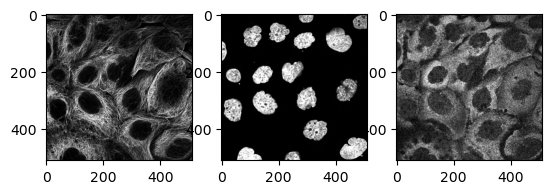

In [9]:
image = load_image(image_paths[hpa], channels, scale_factor)

fig, axes = plt.subplots(1,len(channels))
for i in range(len(channels)):
    axes[i].imshow(image[i,:,:], cmap='gray')

### 2c.Identify Nuclei

In [10]:
axes = cell_model.inputs[0].axes
input_nucleus = DataArray(
    np.concatenate([image[1:2], image[1:2], image[1:2]], axis=0)[None],
    dims=axes
)
padding = {"x": 32, "y": 32}
nuclei_pred = predict_with_padding(pp_nucleus, input_nucleus, padding=padding)[0].values[0]

code/__torch__/torch/nn/functional.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


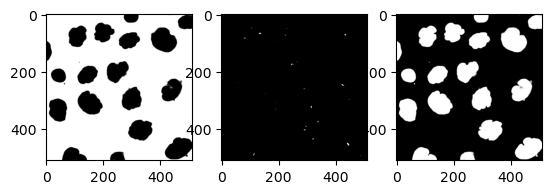

In [11]:
fig, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(nuclei_pred[i,:,:], cmap='gray')

In [12]:
fg = nuclei_pred[-1]
nuclei = label(fg > 0.5)
ids, sizes = np.unique(nuclei, return_counts=True)

In [13]:
filter_ids = ids[sizes < 250]
nuclei[np.isin(nuclei, filter_ids)] = 0

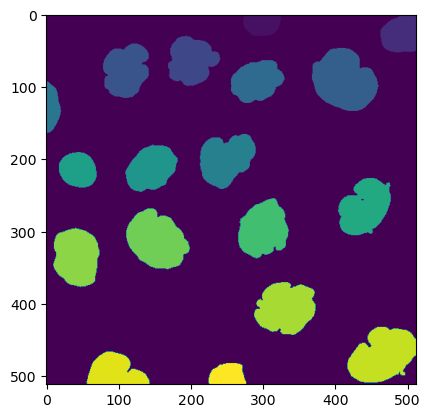

In [14]:
plt.subplots()
plt.imshow(nuclei)

### 2d. Identify Cells

In [15]:
axes = cell_model.inputs[0].axes
input_cells = DataArray(image[None], dims=axes)
cell_pred = predict_with_padding(pp_cell, input_cells, padding=padding)[0].values[0]

code/__torch__/torch/nn/functional.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


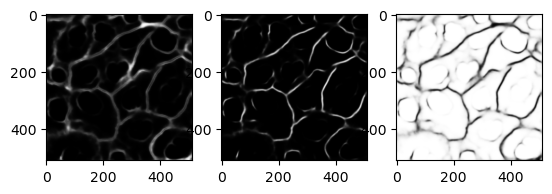

In [16]:
fix, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(cell_pred[i], cmap='gray')

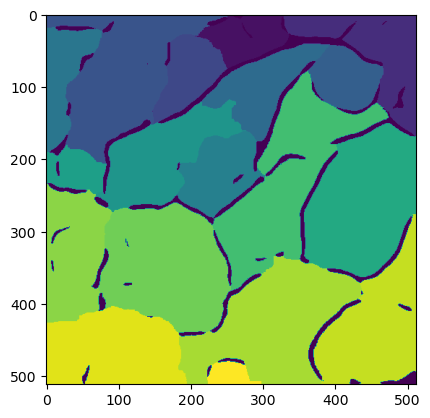

In [17]:
fg, bd = cell_pred[2], cell_pred[1]
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

In [18]:
ids, sizes = np.unique(cell_seg, return_counts=True)

In [19]:
sizes

array([15266,  5767, 12324,  6840, 22675,  6456,  9445,  6931,  8782,
       14720,  3887, 24313, 24611, 24695, 13322, 24829, 18173, 17462,
        1646])

# 3. Exercises

- Explain the parameters provided to watershed().  What happens when you remove mask?  What happens when you remove markers?
- Compare how well segmentation works for cyto, endo, mito, and nucl.  What types of samples work well?  Not as well?

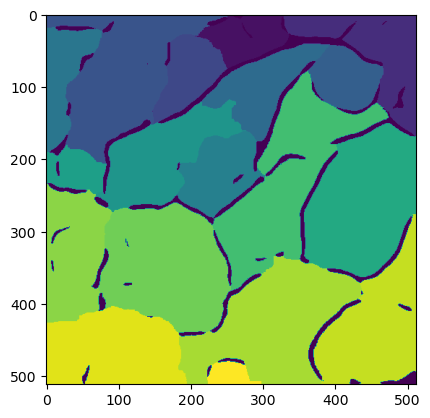

In [20]:
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

In [21]:
hpa = hpa_cyto

Question 2 BioImage: It's creating a mask of the background foreground images 

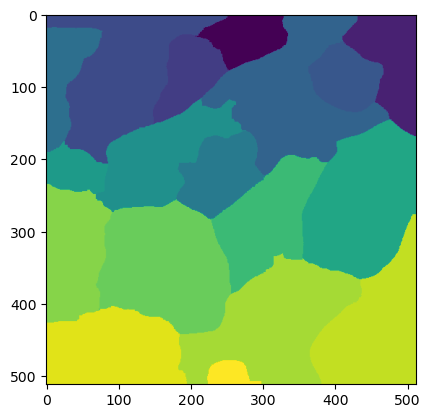

In [22]:
cell_seg = watershed(bd, markers=nuclei)

plt.subplots()
plt.imshow(cell_seg)

You are basically now including the edges or boundries as part of the labeled cell body 

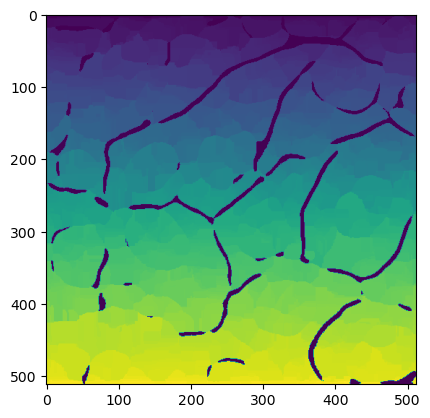

In [23]:
cell_seg = watershed(bd, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

2a. Explain the parameters provided to watershed(). What happens when you remove mask? What happens when you remove markers?

When you remove the mask you are now including the edges and boundries as part of the labeled cell body. Additionally, without the markers, the code is labeling every single variation in the image as a cell body and therefore leaves us with only a gradient. But you can still see some small shapes and outlines as a texture of sorts.    

In [24]:
hpa = hpa_nucl

In [25]:
fg = nuclei_pred[-1]
nuclei = label(fg > 0.5)
ids, sizes = np.unique(nuclei, return_counts=True)

In [26]:
filter_ids = ids[sizes < 250]
nuclei[np.isin(nuclei, filter_ids)] = 0

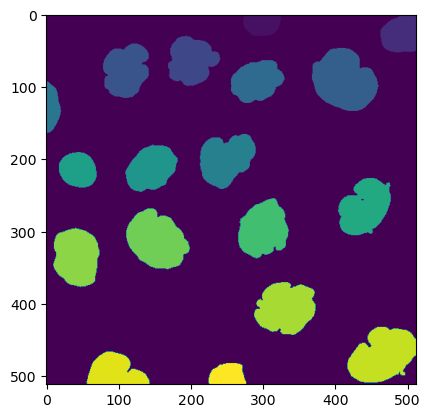

In [27]:
plt.subplots()
plt.imshow(nuclei)

2b. Compare how well segmentation works for cyto, endo, mito, and nucl. What types of samples work well? Not as well?
When comparing these segmentations for each of the conditions, the nuclei work the best as seen above as it provides the best template which watershed can expand from. As for the ER and mitochrondria these conditions provide multiple different starting points in each cell and the cytoplasm is not much better. 